In [136]:
%load_ext autoreload
%autoreload 2
from methods2final import * 
sc.settings.verbosity = 3  
results_file = '../dat/write/pfc2018.h5ad'
sc.settings.set_figure_params(dpi=160)

device = torch.device('cuda:1')
torch.cuda.set_device(1)
print(torch.cuda.current_device())
#X = X.to(device)
def to_var(x):
    return x.to(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1


In [114]:
adata = sc.read_h5ad(results_file)
adata

AnnData object with n_obs × n_vars = 2378 × 4490 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'ID', 'week'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'gene'
    uns: 'pca', 'week_colors'
    obsm: 'X_pca', 'X_tsne'
    varm: 'PCs'

In [115]:
batch_size = 128
dataset = torch.tensor(adata.X)
tensor_max_value = torch.max(dataset)
dataset = dataset/tensor_max_value
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [116]:
vae = VAE2(image_size=4490)
if torch.cuda.is_available():
    print("Model on GPU")
    vae.cuda()
vae

Model on GPU


VAE2(
  (encoder): Sequential(
    (0): Linear(in_features=4490, out_features=2000, bias=True)
    (1): LeakyReLU(negative_slope=0.5)
    (2): Dropout(p=0.5)
    (3): Linear(in_features=2000, out_features=200, bias=True)
    (4): LeakyReLU(negative_slope=0.5)
    (5): Dropout(p=0.5)
    (6): Linear(in_features=200, out_features=20, bias=True)
    (7): LeakyReLU(negative_slope=0.5)
    (8): Dropout(p=0.5)
    (9): Linear(in_features=20, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=2000, bias=True)
    (5): ReLU()
    (6): Linear(in_features=2000, out_features=4490, bias=True)
    (7): Sigmoid()
  )
)

In [117]:

optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
train(data_loader, vae, optimizer, batch_size, epochs=100)

Epoch[1/500] Loss: 219.146
Epoch[51/500] Loss: 191.735
Epoch[101/500] Loss: 195.478
Epoch[151/500] Loss: 185.674
Epoch[201/500] Loss: 186.657
Epoch[251/500] Loss: 187.814
Epoch[301/500] Loss: 186.285
Epoch[351/500] Loss: 195.099
Epoch[401/500] Loss: 193.742
Epoch[451/500] Loss: 185.605


2378


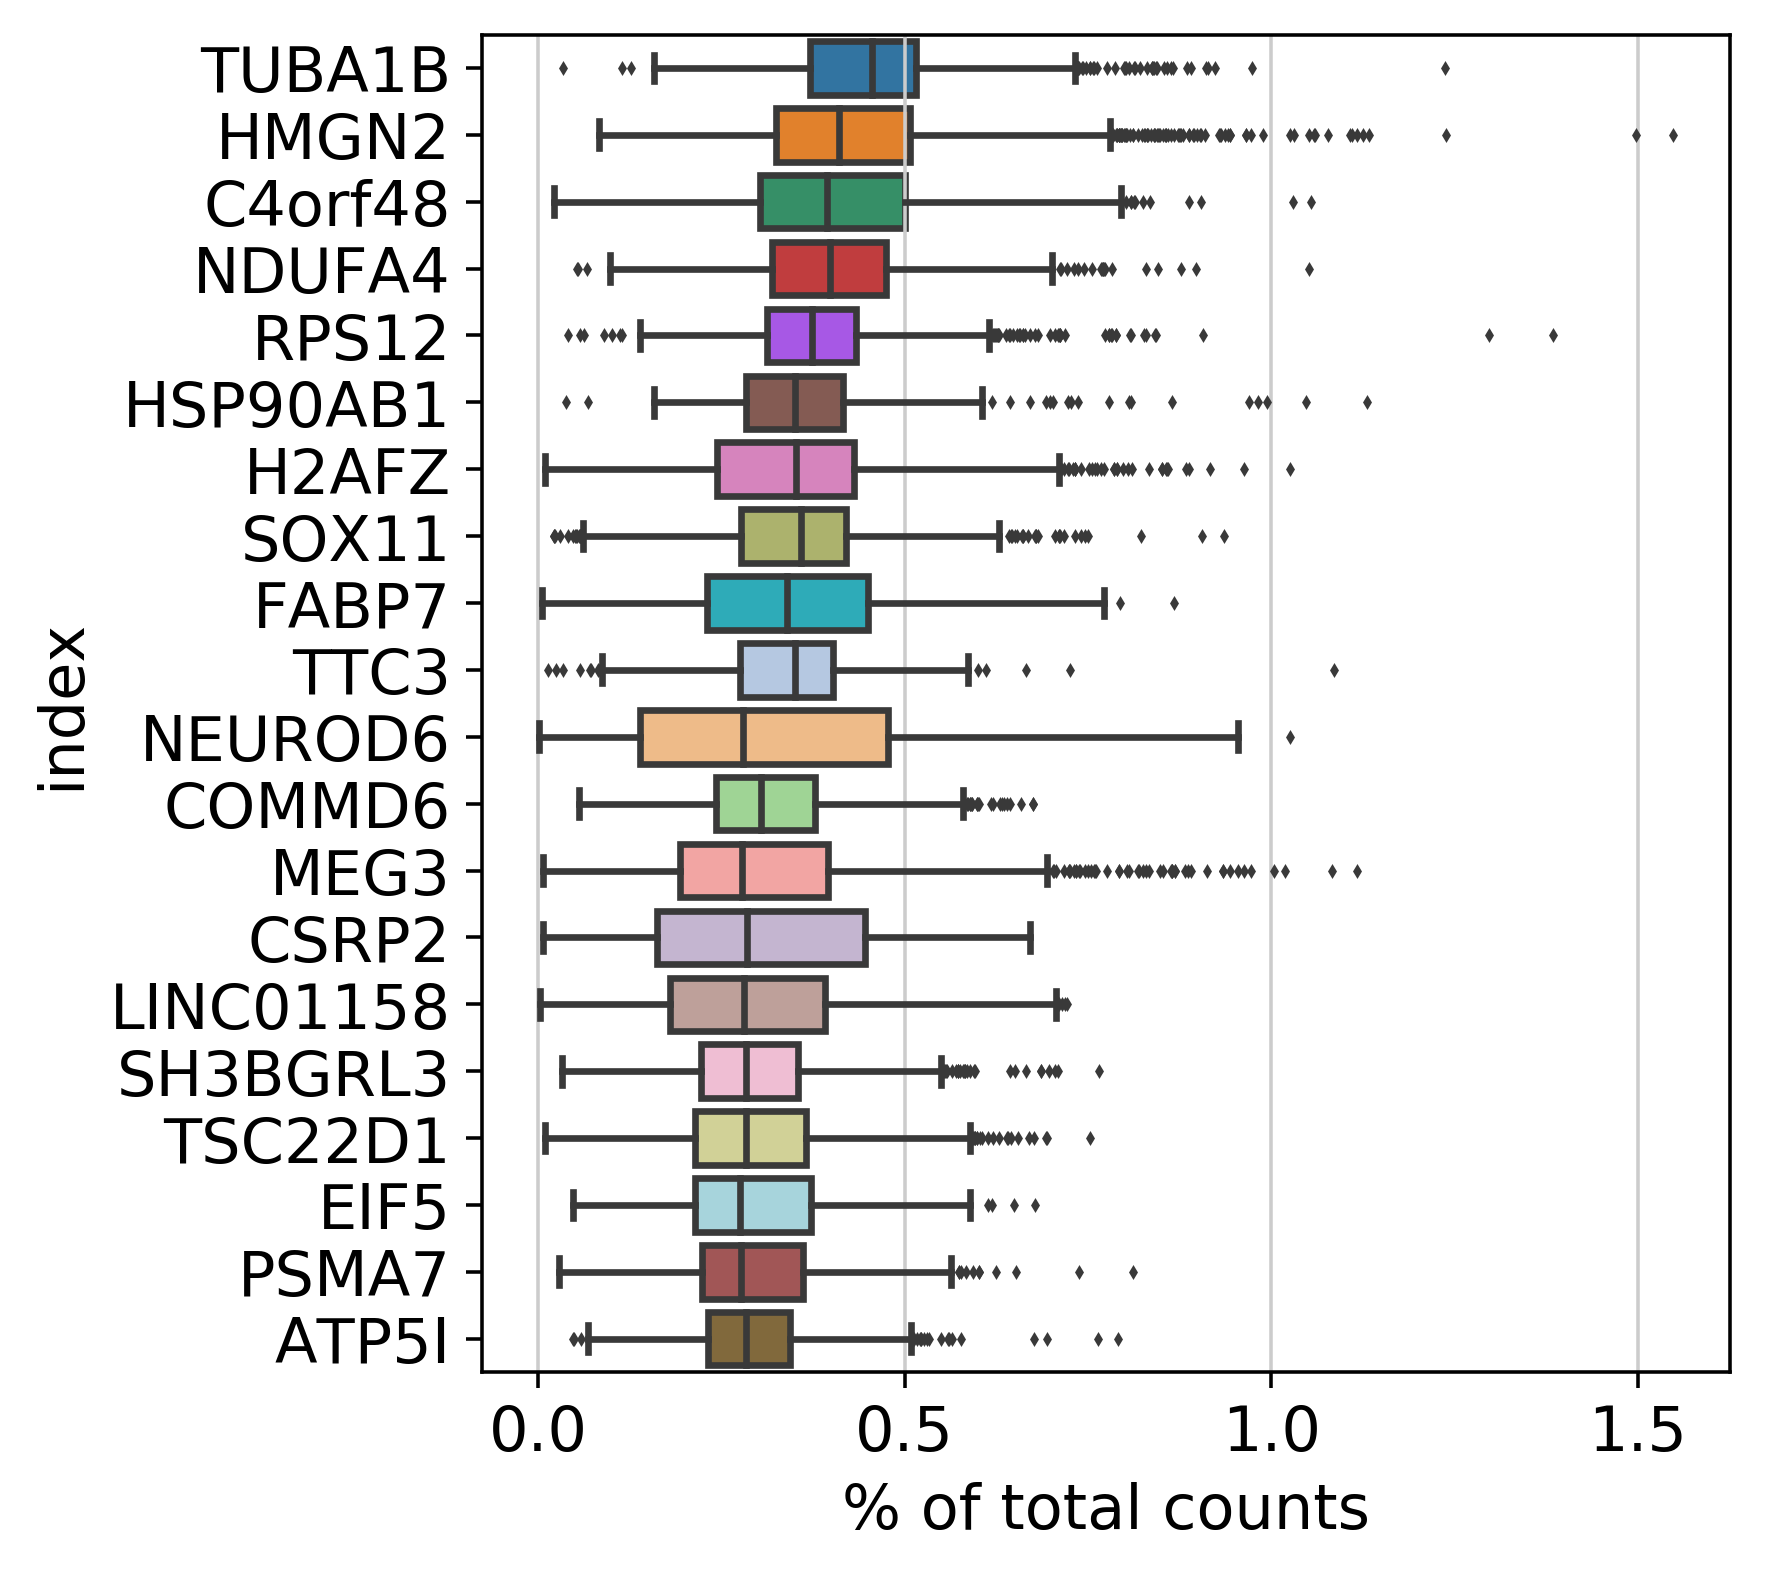

In [118]:
rec_X = vae(to_var(dataset))
print(len(rec_X[0]))
rec_X = rec_X[0].data.cpu()
X = (rec_X*tensor_max_value).detach().numpy()
X.shape
adata.X = X
sc.pl.highest_expr_genes(adata, n_top=20)

computing PCA on highly variable genes


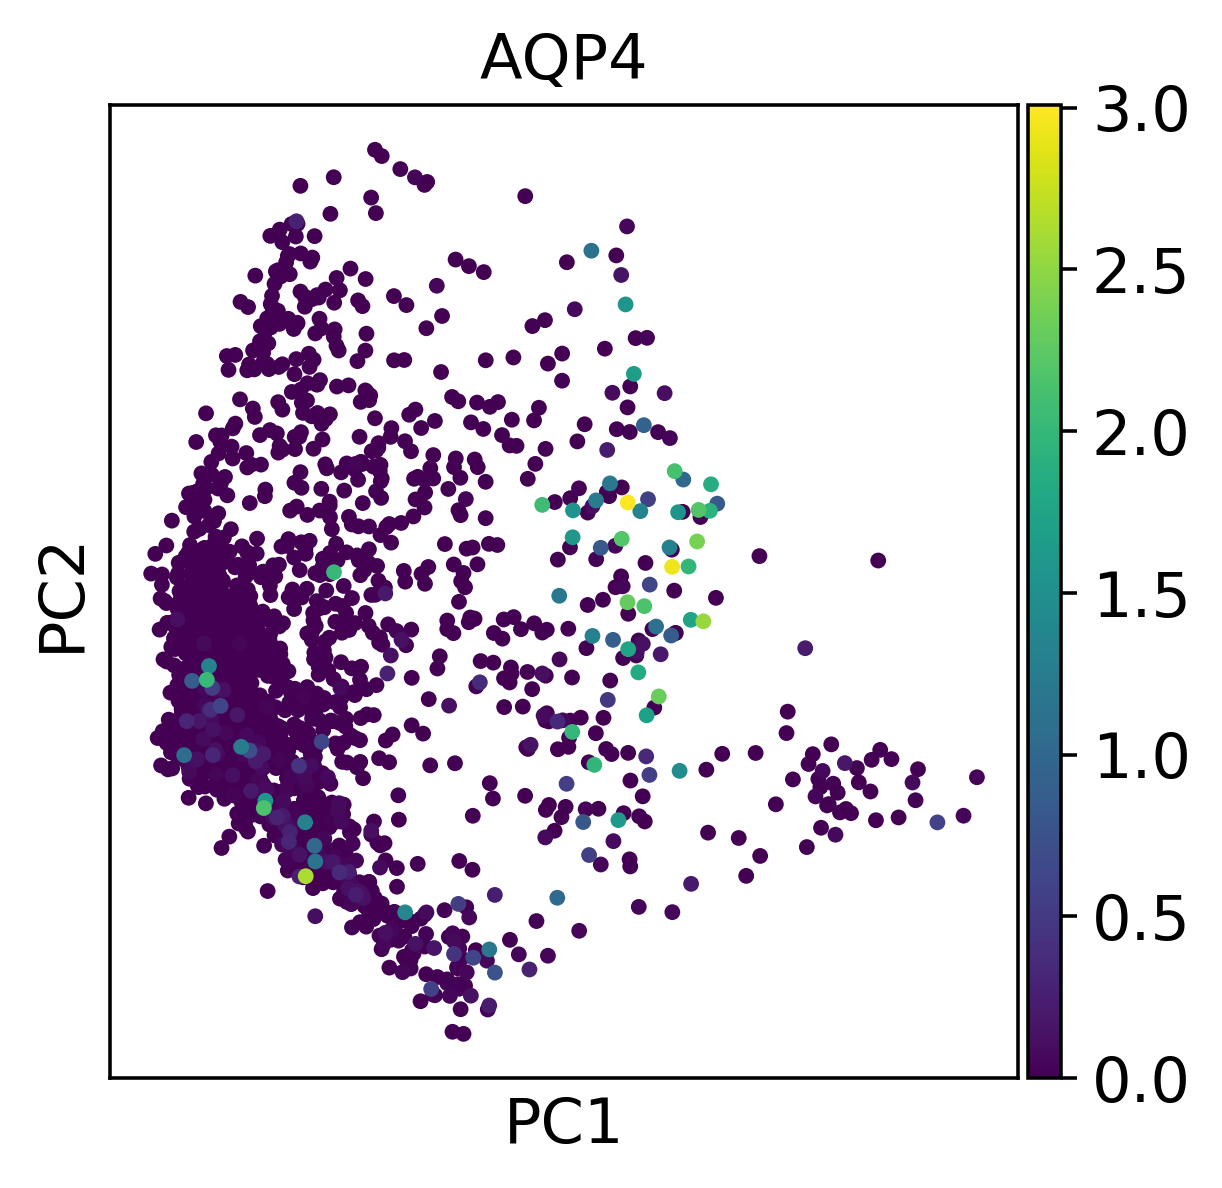

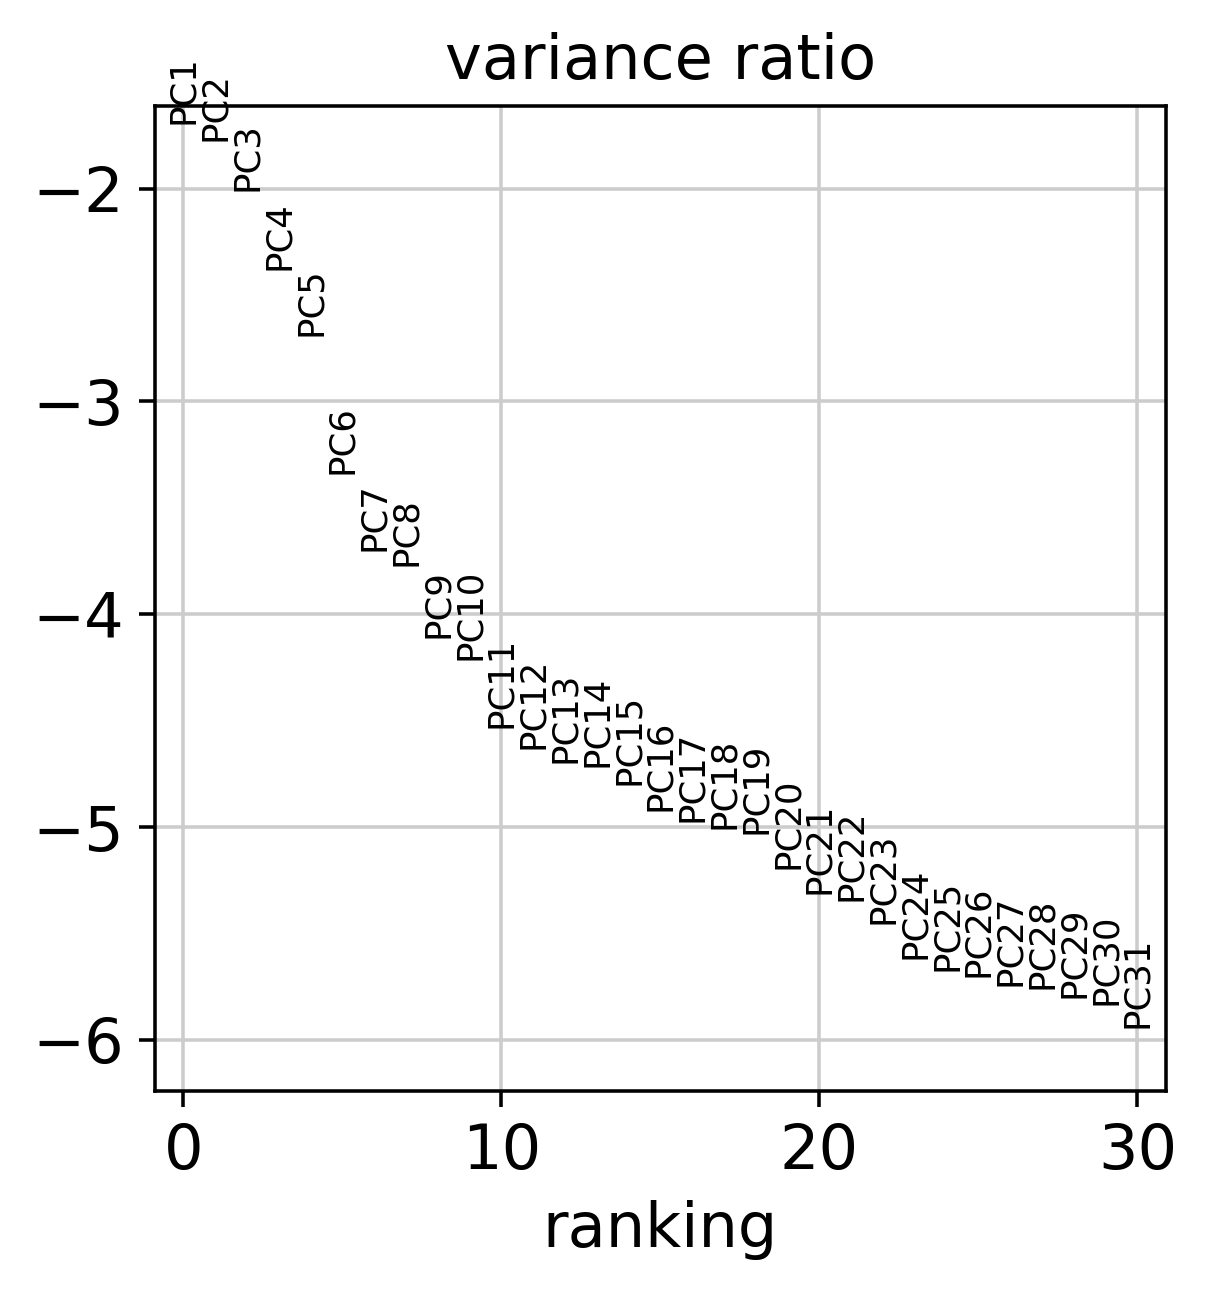

In [119]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='AQP4')
sc.pl.pca_variance_ratio(adata, log=True)

In [120]:
sc.tl.tsne(adata, use_rep='X_pca')

computing tSNE
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:08.87) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


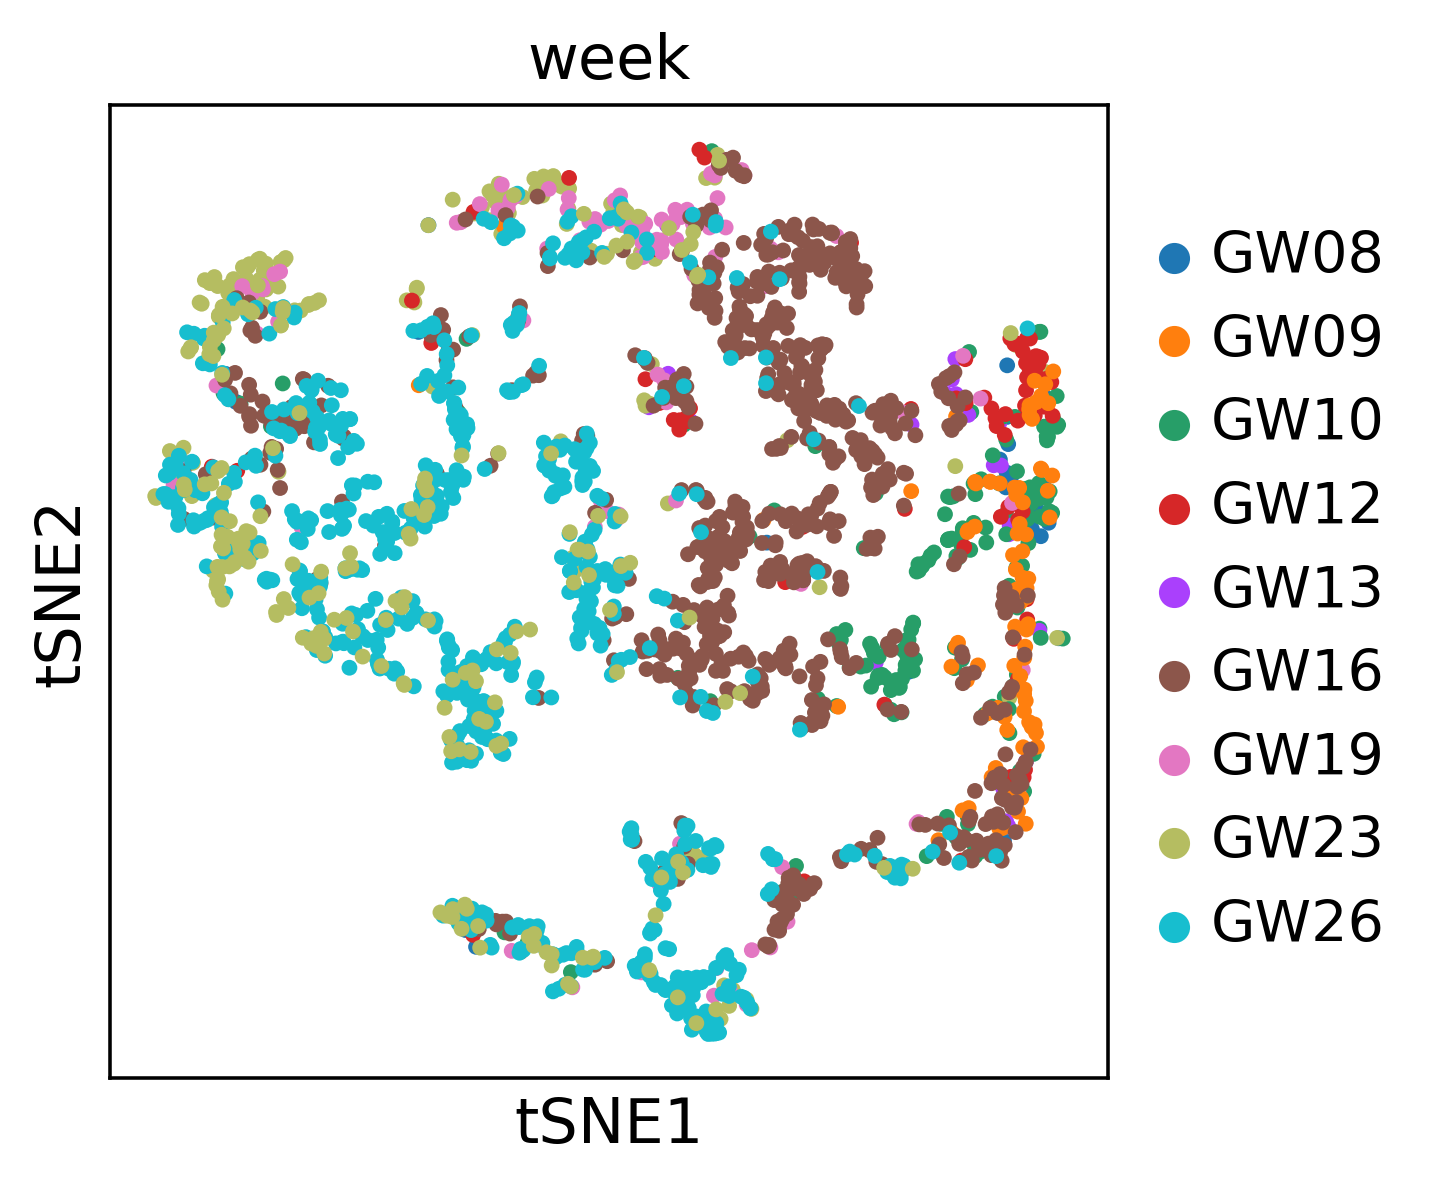

In [121]:
sc.pl.tsne(adata, color='week')

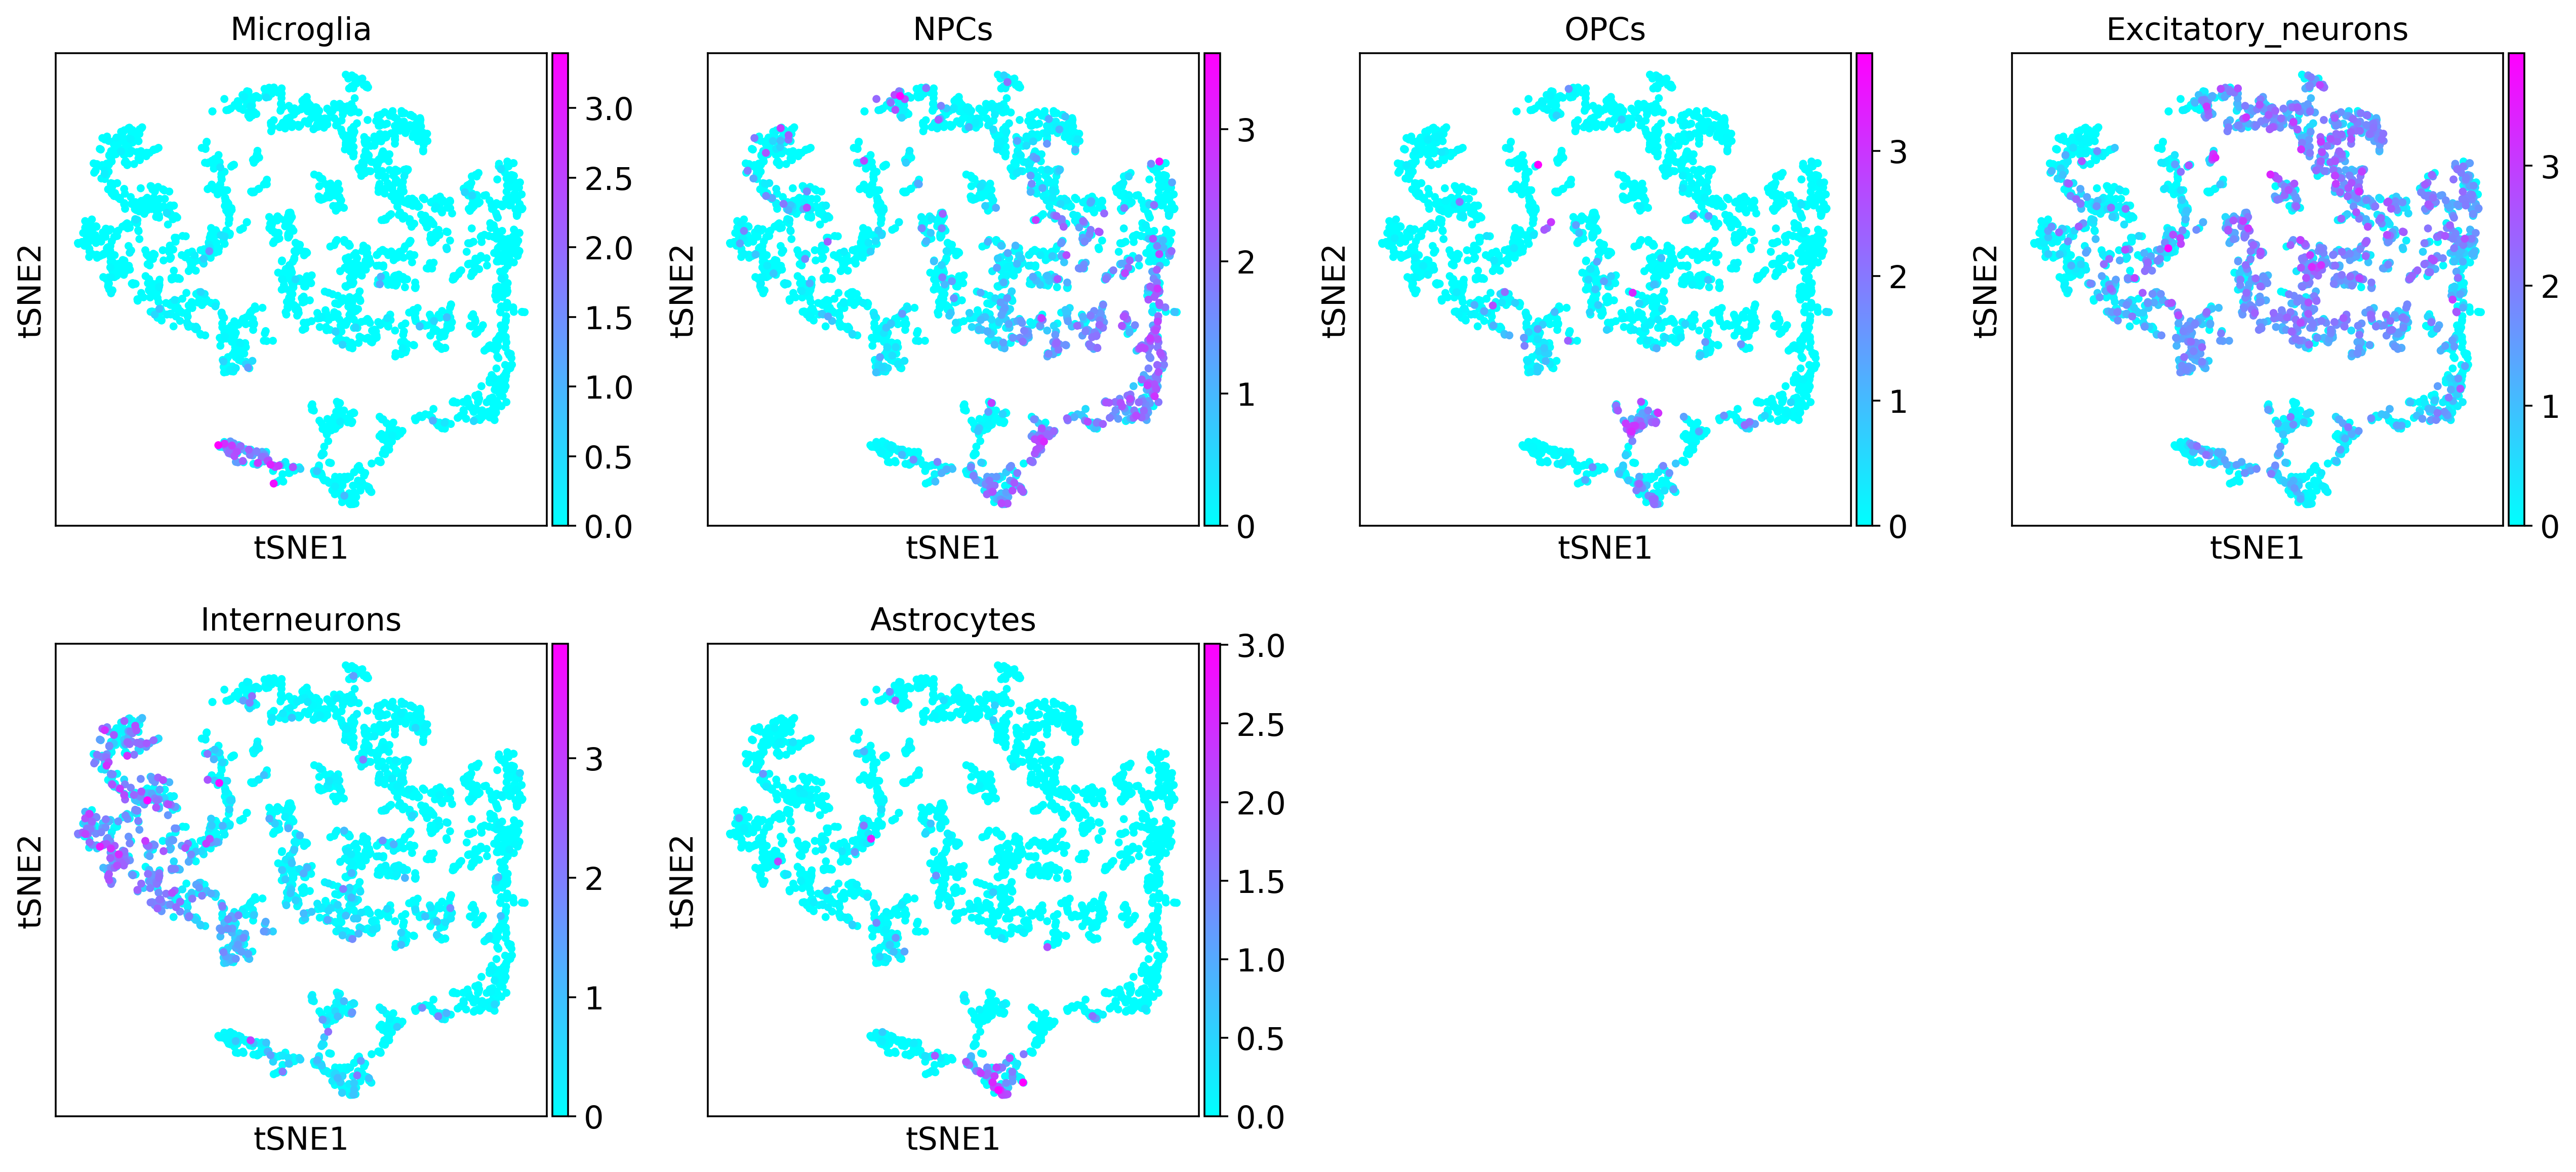

In [122]:
genes = ["PTPRC", "PAX6", "PMP2", "NEUROD2", "GAD1", "AQP4"]
titles = ["Microglia", "NPCs", "OPCs", "Excitatory_neurons", "Interneurons", "Astrocytes"]
sc.pl.tsne(adata, color=genes, title=titles, color_map="cool")

In [123]:
codes = vae.encoder(to_var(dataset))
codes = codes.cpu().detach().numpy()
adata.obsm["X_code400"] = codes

In [124]:
adata.obsm["X_code400"].shape

(2378, 10)

In [150]:
sc.tl.tsne(adata, use_rep='X')

computing tSNE
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:12.15) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


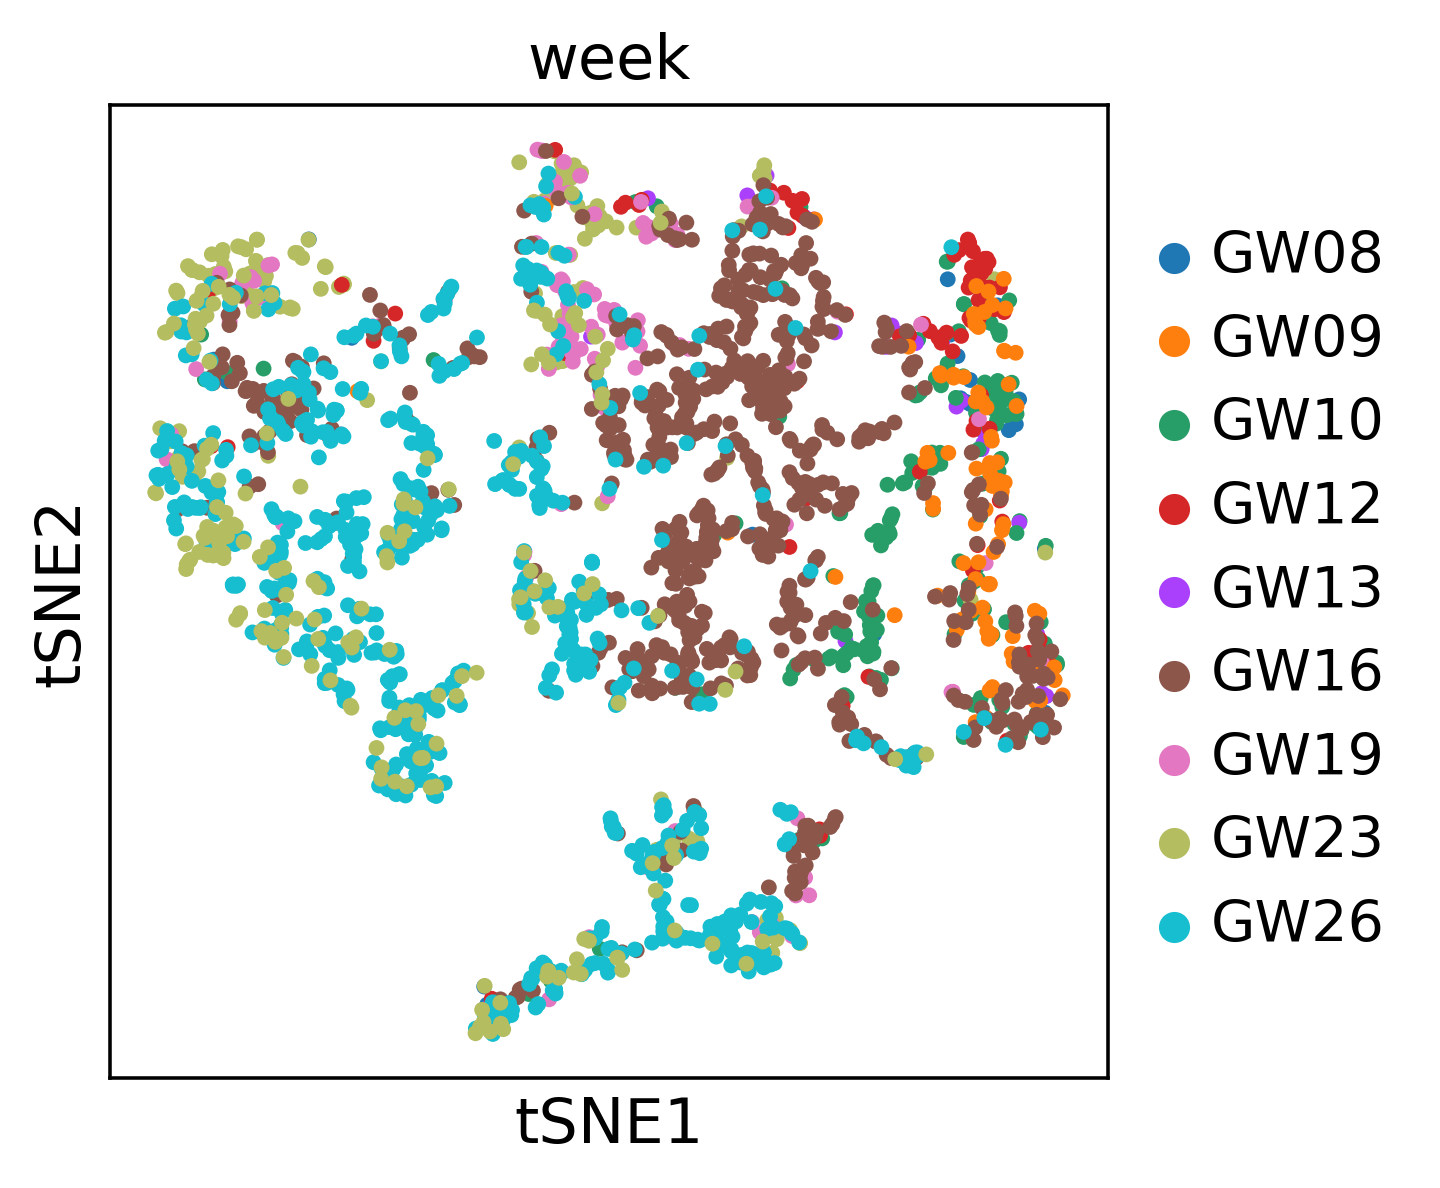

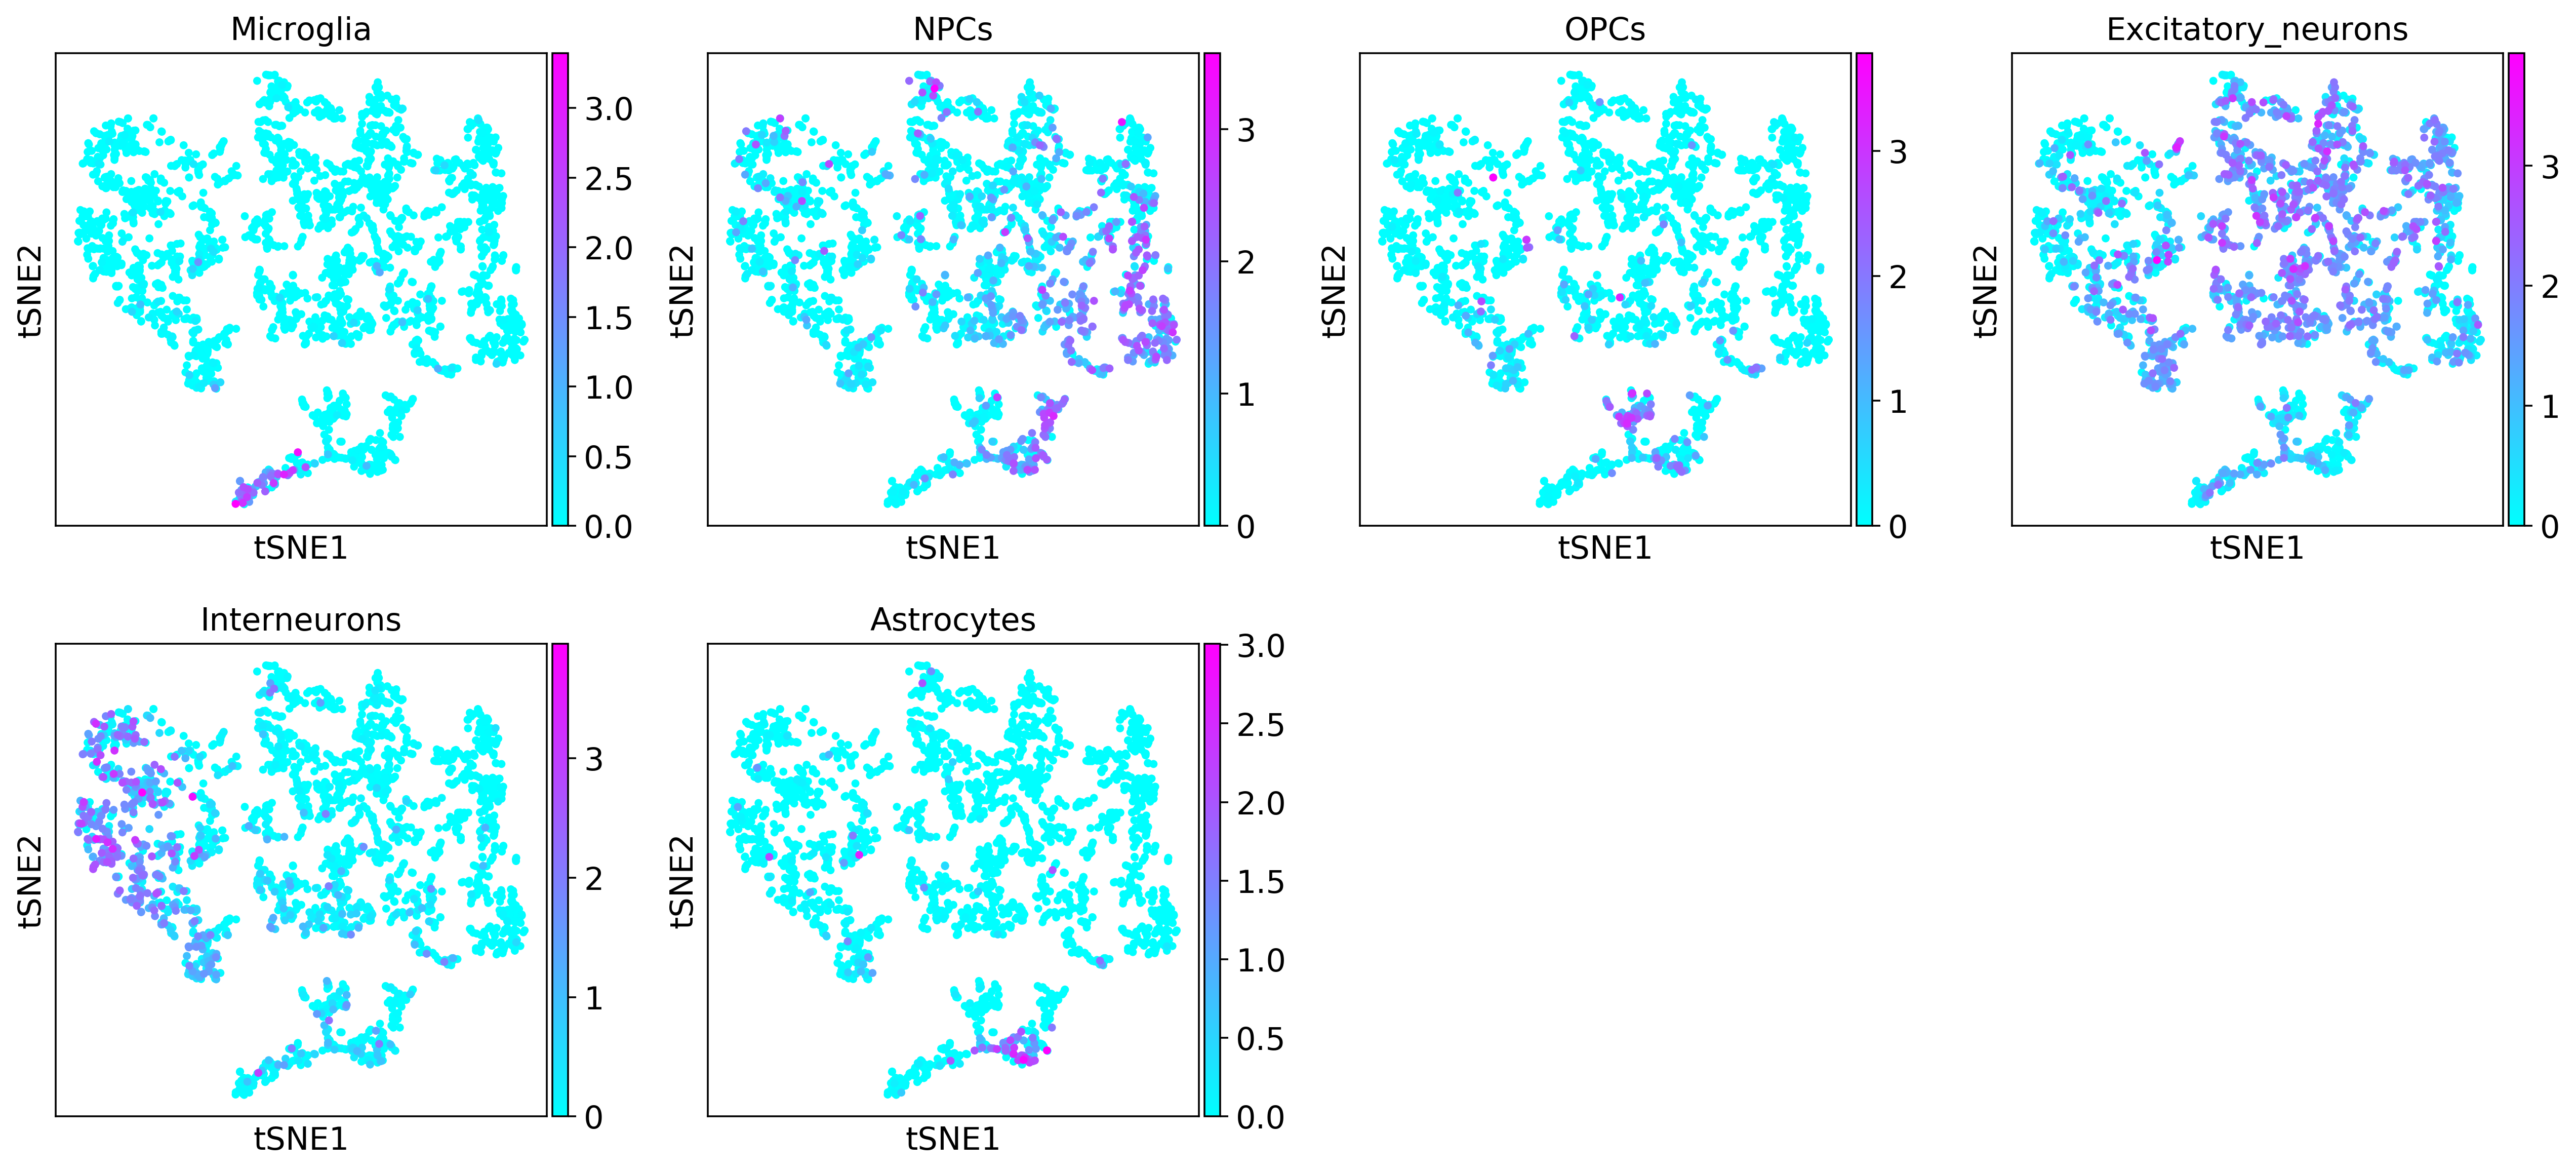

In [151]:
sc.pl.tsne(adata, color='week')
genes = ["PTPRC", "PAX6", "PMP2", "NEUROD2", "GAD1", "AQP4"]
titles = ["Microglia", "NPCs", "OPCs", "Excitatory_neurons", "Interneurons", "Astrocytes"]
sc.pl.tsne(adata, color=genes, title=titles, color_map="cool")

In [137]:
sc.pp.neighbors(adata, n_neighbors=15, use_rep="X_code400")

computing neighbors
    finished (0:00:00.43) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix


In [141]:
sc.tl.dendrogram(adata, groupby="week" ,use_rep="X_code400")

Storing dendrogram info using `.uns['dendrogram_week']`


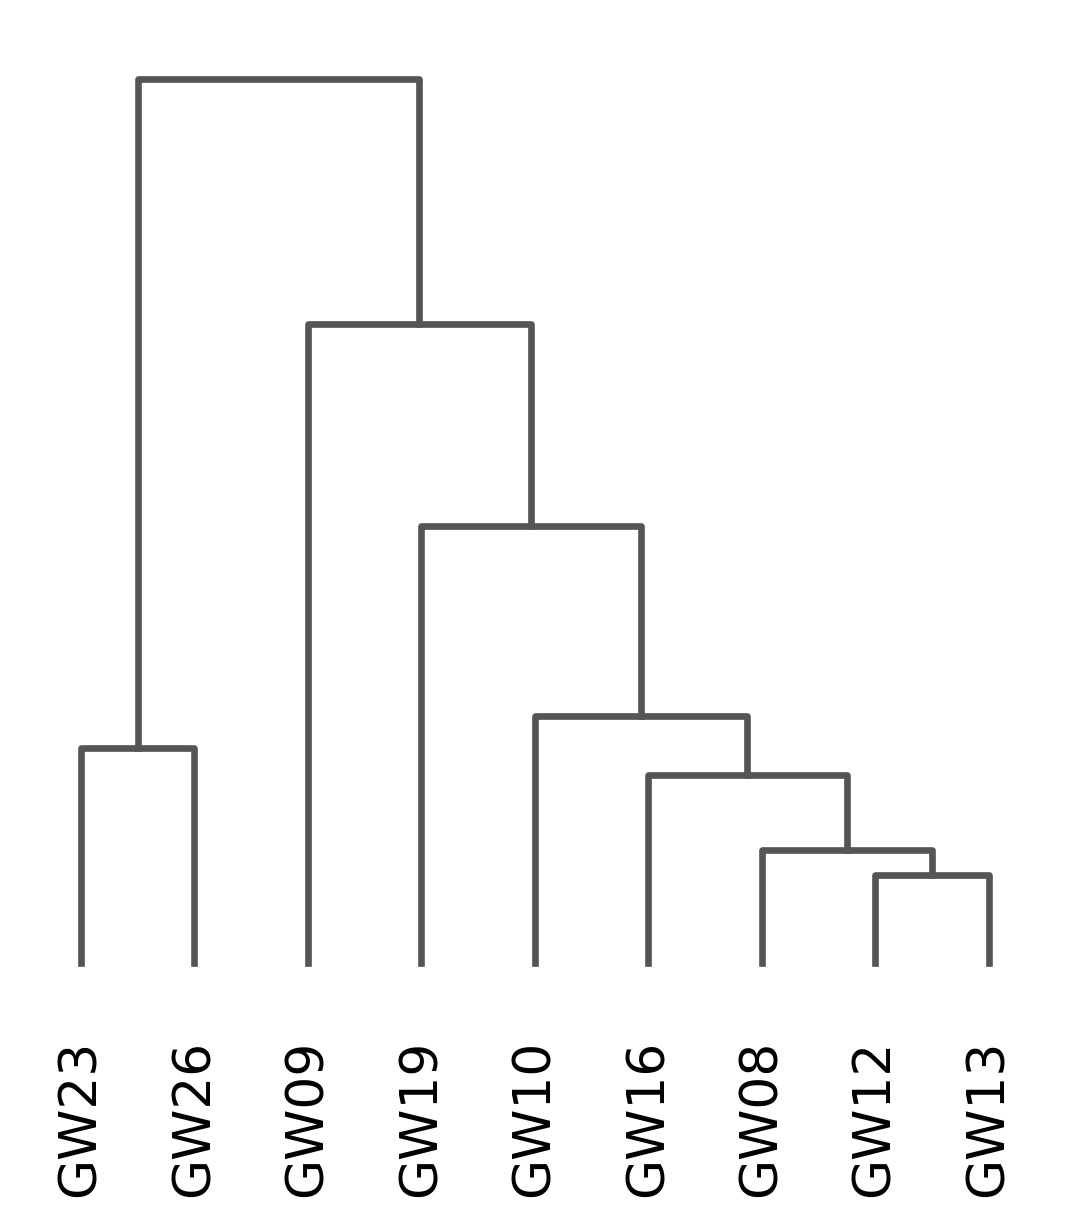

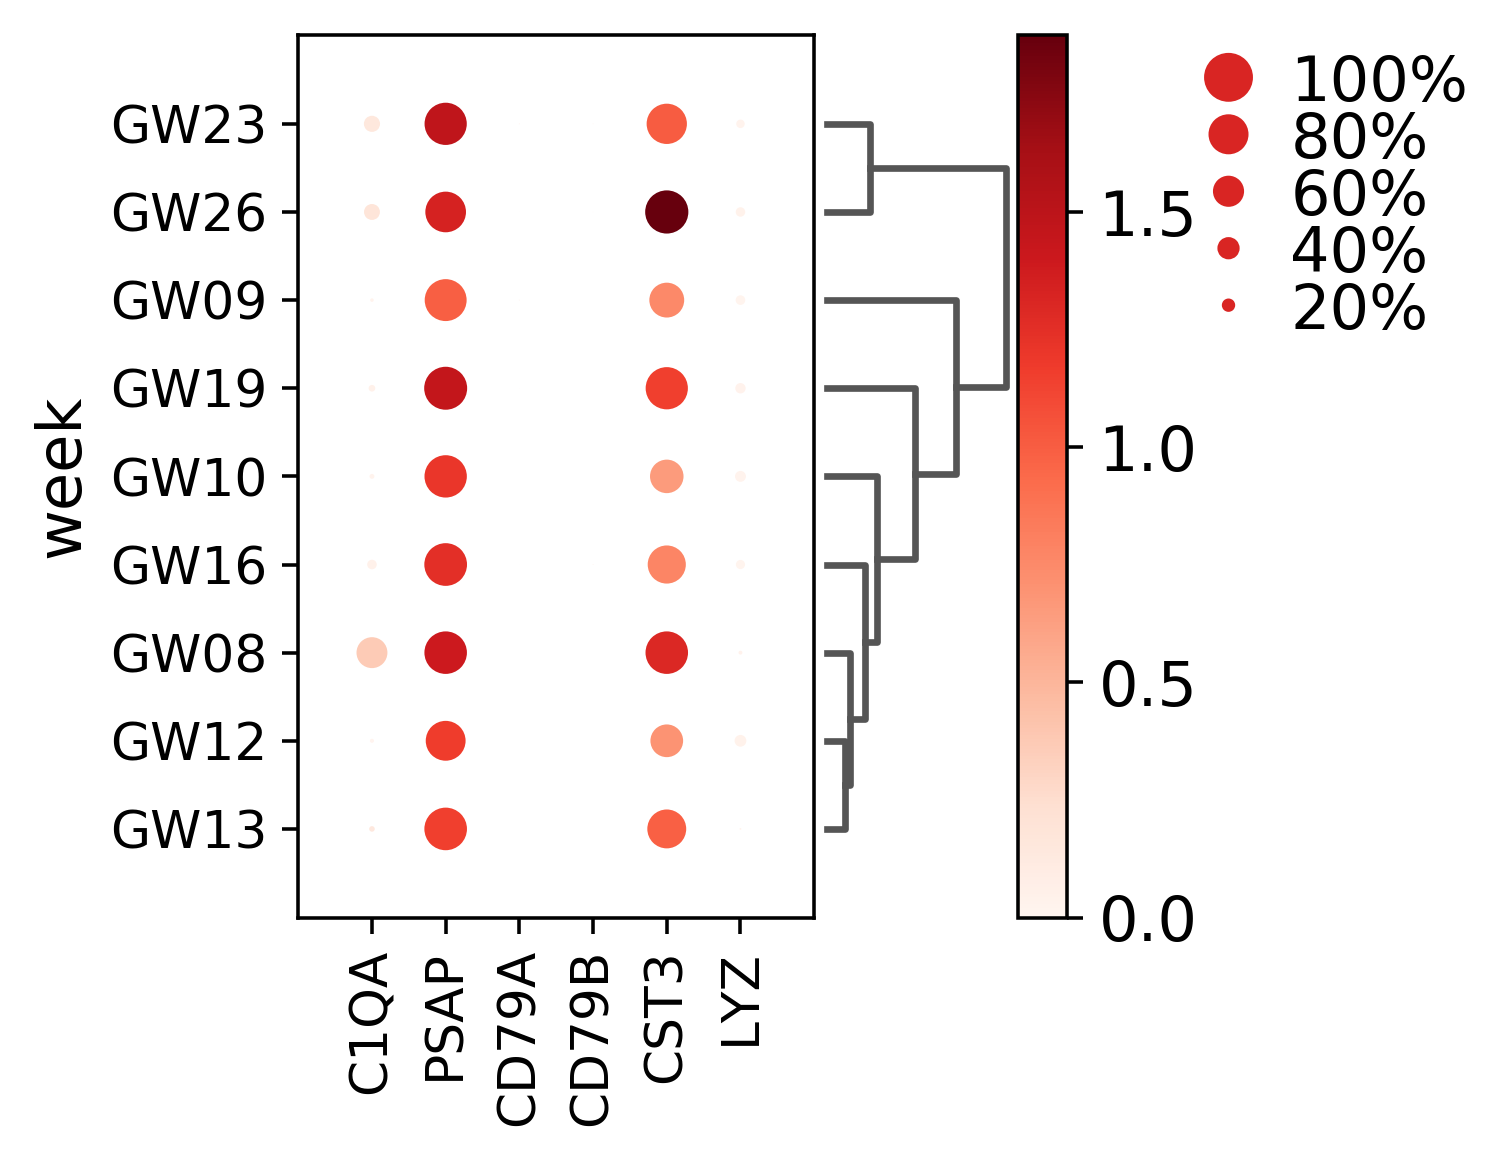

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[2.0999999999999996, 0.8, 0.2, 0.5, 0.25])

In [149]:
sc.pl.dendrogram(adata, groupby="week")
sc.pl.dotplot(adata, ['C1QA', 'PSAP', 'CD79A', 'CD79B', 'CST3', 'LYZ'], groupby='week', dendrogram=True)

In [127]:
adata.obsm["X_code400"]

array([[ -2.1598094 ,   4.015045  ,  -0.28715098, ...,  -5.3488913 ,
         -8.606151  ,  -7.055914  ],
       [ -9.407583  ,  -1.4440001 ,   0.31068707, ..., -12.008732  ,
        -14.584431  , -13.589658  ],
       [ -3.3317003 ,   3.7467272 ,  -2.357083  , ...,  -9.849216  ,
        -13.42988   , -10.685463  ],
       ...,
       [-10.557805  ,  -4.8526297 ,  11.326519  , ...,  -3.3238301 ,
         -4.2039075 ,  -5.3498974 ],
       [-13.929177  ,  -3.311571  ,   9.710264  , ..., -28.248997  ,
        -24.287924  , -23.236973  ],
       [ -6.744644  ,  -1.9157125 ,   4.9495544 , ..., -12.399969  ,
         -9.752515  , -10.032857  ]], dtype=float32)

In [128]:
X, Y = [], []
for x,y in adata.obsm["X_code400"]:
    X.append(x)
    Y.append(y)

ValueError: too many values to unpack (expected 2)

In [ ]:
plt.scatter(X,Y, s=0.1)